# Neural Network assignment
#### Name - Abhisek Mohanty
#### Roll - 18EC3AI20
#### Github repo - https://github.com/AbhisekM2000/MIES-Assignment-3-

<img src="Network.png" width="700" height="300">

## Important to note :
#### The input has 8 features and thus is a 1x8 vector, then we have 8 neurons in the hidden layer and finally we have 3 neurons in the final layer.There are three labels in total, **'M'**, **'F'** and **'I'**, and the neuron out of three which has max value corresponds to the gender/sex.

#### The actual labels are denoted as **'y'**, and are of dimension 1x3, there are basically one-hot encoded vectors, thus for **'M'** we have **[1,0,0]**, **'F'** we have **[0,1,0]** and for **'I'** we have **[0,0,1]**.

#### The loss we apply is the MSE loss.

#### The gradient descent used here is **'Batch Gradient Descent'**, where we take the whole training batch for loss calculation and then we backpropagate/ update the weights and biases.

## Equations for Forward pass and Backpropagation :
<img src="calc.png" width="500" height="200">

## Neural layer class definition


In [2]:
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
import matplotlib.pyplot as plt


class Dense_layer():
    def __init__(self, input_features, layer1_nodes, output_labels, learning_rate, iterations):
        self.weights_layer1 = np.random.rand(
            input_features, layer1_nodes)*0.1  # 8x8 dimension
        self.bias_layer1 = np.zeros((1, layer1_nodes))  # 1x8 dimension
        self.weights_layer2 = np.random.rand(
            layer1_nodes, output_labels)*0.1  # 8x3 dimension
        self.bias_layer2 = np.zeros((1, output_labels))  # 1x3 dimension
        self.learning_rate = learning_rate
        self.iterations = iterations

    def sigmoid(self, input):  # Calculates the sigmoid for a given input
        return 1/(1+np.exp(-input))

    # Calculates the sigmoid derivative for a given input
    def sigmoid_derivative(self, input):
        return np.exp(-input) / ((1 + np.exp(-input)) ** 2)

    def forward(self, input):
        # The below is the output of layer 1 (hidden layer ), first its passed through a linear layer and then sigmoid activated
        # a1 in the above equation
        self.output_layer1 = np.dot(
            input, self.weights_layer1)+self.bias_layer1
        self.activated_output_layer1 = self.sigmoid(
            self.output_layer1)  # z1 in the above equation

        # The below is the output of layer 2, first its passed through a linear layer and then sigmoid activated
        # a2 in the above equation
        self.output_layer2 = np.dot(
            self.activated_output_layer1, self.weights_layer2)+self.bias_layer2
        self.activated_output_layer2 = self.sigmoid(
            self.output_layer2)  # a2 in the above equation

    def calc_loss(self, predicted_label, actual_label):  # Function to calculate the loss
        len=predicted_label.shape[0]
        return (0.5*np.sum(np.square((predicted_label-actual_label))))/len

    def backward(self, input, y_pred, y_actual):  # Function to calculate the derivatives

        # Calculation of the derivatives of loss
        self.loss_derivative2 = np.multiply(
            (y_pred-y_actual), self.sigmoid_derivative(self.output_layer2))
        self.loss_derivative1 = np.dot(
            self.loss_derivative2, self.weights_layer2.T)*self.sigmoid_derivative(self.output_layer1)

        self.layer2_weight_derivative = np.dot(
            self.activated_output_layer1.T, self.loss_derivative2)
        self.layer2_bias_derivative = 1 / \
            input.shape[0] * \
            (np.sum(self.loss_derivative2, axis=0).reshape(1, 3))

        self.layer1_weight_derivative = np.dot(input.T, self.loss_derivative1)
        self.layer1_bias_derivative = 1 / \
            input.shape[0] * \
            (np.sum(self.loss_derivative1, axis=0).reshape(1, 8))

    # In this function we update the parameters
    def update_parameters(self, dW1, db1, dW2, db2): #The weights are updates using Batch Gradient descent algorithm
        self.weights_layer1 -= (self.learning_rate * dW1)
        self.bias_layer1 -= (self.learning_rate*db1)
        self.weights_layer2 -= (self.learning_rate * dW2)
        self.bias_layer2 -= (self.learning_rate*db2)

    def train(self, input, y_actual):  # Function to train the model
        self.forward(input)  # We first forward pass
        # Calculate and store the loss generated
        loss = self.calc_loss(self.activated_output_layer2, y_actual)
        # Then we calculate the derivatives from the Loss function
        self.backward(input, self.activated_output_layer2, y_actual)
        self.update_parameters(self.layer1_weight_derivative, self.layer1_bias_derivative, self.layer2_weight_derivative,
                               self.layer2_bias_derivative)  # Then we backpropagate and update the model parameters(weights and biases)

        return loss

    def predict(self,input): #Predicts the label for a given input
        self.forward(input) #We for ward pass the input into the neural network
        index=np.argmax(self.activated_output_layer2) #find the index with maximum value in the 1x3 numpy vector
        if index==0:
            return 'M'
        elif index==1:
            return 'F'
        else:
            return 'I'

    def calc_accuracy(self,input,y_actual): #Used to calculate accuracy for any given dataset with input as dataset and y_actual as the output actual labels
        self.forward(input) #We for ward pass the input into the neural network
        y_predicted = self.activated_output_layer2 #The last layer gives us the predicted values
        correct = 0
        for i in range(len(input)): #We calculate the labels identified correctly by our network
            if np.where(y_predicted[i] == max(y_predicted[i])) == np.where(y_actual[i] == max(y_actual[i])):
                correct += 1
        
        return (correct/len(input))
        


## Dataset creation

#### In the below we have functions to create dataset, the **split_data** takes df which is the dataframe and ratio which is basically the ratio we want to divide our training data into and returns us the following :
```
1. train - the training dataset
2. Y_train - the output labels for the training dataset
3. test - the test dataset
4. Y_test- the output labels for the test dataset
```

In [3]:
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
import matplotlib.pyplot as plt


# Function to split the dataset into a given ratio ( ratio = percentage of training set)
def split_dataset(df, ratio):
    # We split the data as per the given ratio
    train = df.sample(frac=ratio)
    test = df.drop(train.index)

    # Then we make the indexing of each in a sequential manner
    test.reset_index(inplace=True, drop=True)  # Make proper indexing
    train.reset_index(inplace=True, drop=True)  # Make proper indexing

    # We store the gender for the train and test set separately
    gender_dataset_train = train['sex']
    gender_dataset_test = test['sex']

    # We drop the gender/sex column and the Id column from both train and test dataset
    train = train.drop('sex', axis=1)
    train = train.drop('Id', axis=1)

    test = test.drop('sex', axis=1)
    test = test.drop('Id', axis=1)

    # Then we convert the train and test set to numpy array and then we normalize the whole dataset
    train = train.to_numpy()
    train = (train - train.min(axis=0)) / \
        (train.max(axis=0) - train.min(axis=0))
    test = test.to_numpy()
    test = (test - test.min(axis=0)) / (test.max(axis=0) - test.min(axis=0))

    # Finally we form the output vector(actual output labels) which is one-hot encoded that is 'M'=[1,0,0], 'F'=[0,1,0] and 'I'=[0,0,1]
    Y_train = np.zeros((len(train), 3))
    for i in range(len(train)):
        if gender_dataset_train[i] == 'M':
            Y_train[i][0] = 1
        elif gender_dataset_train[i] == 'F':
            Y_train[i][1] = 1
        else:
            Y_train[i][2] = 1

    Y_test = np.zeros((len(test), 3))
    for i in range(len(test)):
        if gender_dataset_test[i] == 'M':
            Y_test[i][0] = 1
        elif gender_dataset_test[i] == 'F':
            Y_test[i][1] = 1
        else:
            Y_test[i][2] = 1

    return train, Y_train, test, Y_test


## Scatter plot functions

#### We have two functions here **scatter_plot** and **scatter_plot_normalized**, both take the same set of parameters, **df** which is the dataframe, **gender_label** which are the gender labels (M,F or I) for the dataframe, **column1** and **column2** are the column number of the two feature columns which we desire to scatter plot for

In [4]:
from numpy.core.numeric import correlate
from nn import Dense_layer
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


def scatter_plot(df, gender_label, column1, column2):
    df_numpy = df.to_numpy()
    plt.figure(num=1)
    color = ['blue', 'red', 'yellow']
    for i in range(3):
        if i == 0:
            gender = 'M'
        elif i == 1:
            gender = 'F'
        elif i == 2:
            gender = 'I'
        x = []
        y = []
        for j in range(len(gender_label)):
            if gender_label[j] == gender:
                x.append(df_numpy[j][column1])
                y.append(df_numpy[j][column2])
        plt.scatter(x, y, c=color[i], label=gender)
    plt.legend(loc='best')
    plt.xlabel(df.columns[column1])
    plt.ylabel(df.columns[column2])
    plt.title("Scatter plot between " +
              df.columns[column1] + " and " + df.columns[column2])


def scatter_plot_normalized(df, gender_label, column1, column2):
    # We drop the 'sex' axis so that we can normalize the dataframe
    df_dropped = df.drop('sex', axis=1)
    df_numpy = df_dropped.to_numpy()  # We convert it to numpy array
    df_norm = (df_numpy - df_numpy.min(axis=0)) / (df_numpy.max(axis=0) -
                                                   df_numpy.min(axis=0))  # Now we normalize the datapoints

    plt.figure(num=2)
    # We take these three colours for 3 different genders
    color = ['blue', 'red', 'yellow']
    for i in range(3):
        if i == 0:
            gender = 'M'
        elif i == 1:
            gender = 'F'
        elif i == 2:
            gender = 'I'
            # We use
        x = []
        y = []
        for j in range(len(gender_label)):
            if gender_label[j] == gender:
                x.append(df_norm[j][column1])
                y.append(df_norm[j][column2])
        plt.scatter(x, y, c=color[i], label=gender)
    plt.legend(loc='best')
    plt.xlabel(df.columns[column1])
    plt.ylabel(df.columns[column2])
    plt.title("Normalized scatter plot between " +
              df.columns[column1] + " and " + df.columns[column2])


## Main function

#### In the main function we are doing the following things
```
1. Reading the dataset and storing it in a variable df
2. Plotting the scatter plots wrt any two features as per choice
3. We define our model in the variable 'neural_net'
4. Divide the dataset into train and test with labels Y_train and Y-test respectively
5.Train the model for 500 epochs, and after every epoch we calculate and store the loss, training accuracy and the testing accuracy respectively
6. Then we print the final training and test accuracies
7. Then we plot the model statistics and analyse the plots

```

Training accuracy =  0.5421903052064632
Test accuracy =  0.518562874251497


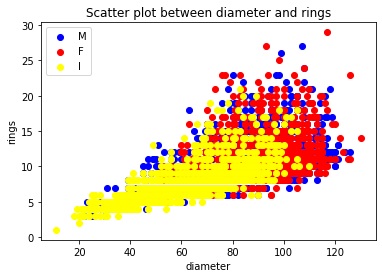

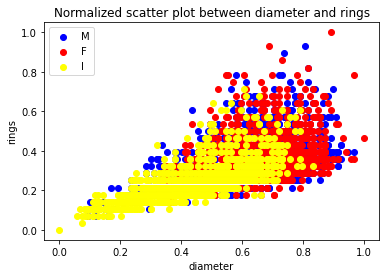

In [5]:
'''
We plot the features with respect to the sex using scatter plot
'''
df = pd.read_csv('Snails.csv')

feature_index={
    'length':1,
    'diameter':2,
    'height':3,
    'whole-weight':4,
    'shucked-weight':5,
    'viscera-weight':6,
    'shell-weight':7,
    'rings':8
}

#We give any two features we want to plot the scatter plot for
feature_1_column = feature_index['diameter']
feature_2_column = feature_index['rings']

scatter_plot(df, df['sex'], feature_1_column, feature_2_column)
scatter_plot_normalized(df, df['sex'], feature_1_column, feature_2_column)


'''
We define our model here

input_features=8
layer1_nodes=8, since there are 8 nodes in the hidden layer
output_labels=3, since there are 3 labels, M,F and I
learning_rate=0.01
iterations=500
'''
neural_net = Dense_layer(input_features=8, layer1_nodes=8,
                         output_labels=3, learning_rate=0.01, iterations=500)
train, Y_train, test, Y_test = split_dataset(df, ratio=0.8)

EPOCHS = 500
loss = []  # Store the loss after each epoch
accuracy_train = []  # Store the training accuracy after each epoch
accuracy_test = []  # Store the testing accuracy after each epoch

for j in range(EPOCHS):
    epoch_loss = neural_net.train(train, Y_train)
    training_accuracy = neural_net.calc_accuracy(train, Y_train)
    test_accuracy = neural_net.calc_accuracy(test, Y_test)

    loss.append(epoch_loss)
    accuracy_train.append(training_accuracy)
    accuracy_test.append(test_accuracy)


'''
Training accuracy
In this we pass the training dataset and calculate accuracy
'''
print("Training accuracy = ", neural_net.calc_accuracy(train, Y_train))


'''
Test accuracy
In this we pass the test dataset and calculate accuracy
'''
print("Test accuracy = ", neural_net.calc_accuracy(test, Y_test))



## Model analysis and statistics

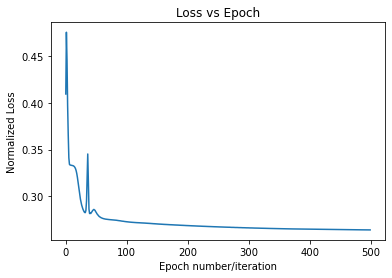

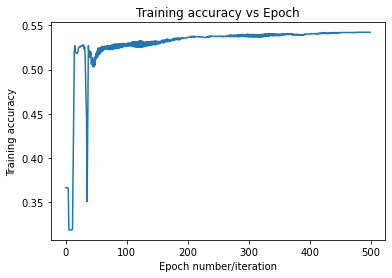

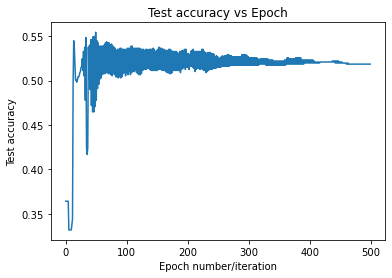

In [6]:
'''
We plot the
1. Loss vs Epoch
2. Training accuracy vs Epoch
3. Testing accuracy vs Epoch
'''
plt.figure(num=3)
plt.title("Loss vs Epoch")
plt.xlabel("Epoch number/iteration")
plt.ylabel("Normalized Loss")
plt.plot(loss)

plt.figure(num=4)
plt.title("Training accuracy vs Epoch")
plt.xlabel("Epoch number/iteration")
plt.ylabel("Training accuracy")
plt.plot(accuracy_train)


plt.figure(num=5)
plt.title("Test accuracy vs Epoch")
plt.xlabel("Epoch number/iteration")
plt.ylabel("Test accuracy")
plt.plot(accuracy_test)
plt.show()